In [1]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# The QUEST

In [2]:
# ADAM NOTE: leaving this as a help table for future

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Unified Imports cell 
# (Adam note: I won't let the mess from the previous merge notebook happen again)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFilter
# from tensorflow.keras.preprocessing.image import ImageDataGenerator DEPRECATED
from pathlib import Path
import kagglehub
import math
import tensorflow as tf

# ### Adam Candrák/Mária Matušisková - 50%/50%

-------------------------------------------------------------------------------------------
## Image classification 
-------------------------------------------------------------------------------------------

As the quest we wan't to tackle, we choose- "3 Way Classification - COVID-19, Viral Pneumonia, Normal" from the dataset provided by the [Covid-19 Image Dataset](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset/data). The dataset contains 3 types of images: COVID-19, Viral Pneumonia and Normal. The dataset is already divided into training and testing sets. Each of these folders is divided into 3 folders, each containing images of one of the types. 

The training set contains **251** images and the testing set contains **66** images.

The goal is to create a model that will be able to classify the images into one of the three categorie.

Data download:

In [4]:
# Download latest version
path = kagglehub.dataset_download("pranavraikokte/covid19-image-dataset")

print("Path to dataset files:", path)


Path to dataset files: /Users/maria/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2


-------------------------------------------------------------------------------------------
## 4.1 EDA
-------------------------------------------------------------------------------------------
First let's take a look at the data. W some images will loadm in a grid.

In [12]:
TRAIN_PATH = os.path.join(path, 'Covid19-dataset', 'train')
TEST_PATH = os.path.join(path, 'Covid19-dataset', 'test')
# method source: 'https://www.kaggle.com/code/justicevil/covid19-image-classification-vgg16-val-acc-98' the is ImageDataGenerator deprecated
# so we will replace it's function with something current

height, width = 227, 227
batch_size = 32
class_names = ['Normal', 'Viral Pneumonia', 'Covid']

def create_dataset(path):
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        # resize images
        image_size=(height, width),
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        label_mode='categorical',
        class_names=class_names
    )

    # optimise performance for training
    ds = ds.cache().shuffle(1000)
    # it is friendly to PC resources
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    # rescale pixel values
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
    
    return ds

train_ds = create_dataset(TRAIN_PATH)
test_ds = create_dataset(TEST_PATH)

# extract labels 
## CLAUDE.AI (because of the error out of range)
def get_labels(dataset):
    labels = []
    for _, y in dataset.as_numpy_iterator():
        labels.append(y)
    return np.concatenate(labels)
##

train_labels = get_labels(train_ds)
test_ds_labels = create_dataset(TEST_PATH) 
test_labels = get_labels(test_ds_labels)
all_labels = np.concatenate([train_labels, test_labels])

print(f"Total number of images: ", len(all_labels))
for i, class_name in enumerate(class_names):
    count = np.sum(np.argmax(all_labels, axis=1) == i)
    print(f"{class_name} cases: {count}")

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.
Found 66 files belonging to 3 classes.
Total number of images:  317
Normal cases: 90
Viral Pneumonia cases: 90
Covid cases: 137


The main function of this code is:
1. Images are resized to 224x224 pixels and rescaled to [0,1] range
2. Uses batch size of 64
3. Assigns one-hot encoding for labels (|1|0|0| - normal, |0|1|0| - pneu, |0|0|1| - covid)
4. Enables shuffling with fixed random seed (42)

Let's now graphicly show some data to visualy inspect.

In [15]:
def plot_images(ds):
    fresh_ds = ds.repeat()
    plt.figure(figsize=(10, 10))
    for images, labels in ds.take(1):
        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(class_names[np.argmax(labels[i])])
            plt.axis('off')
    plt.show()

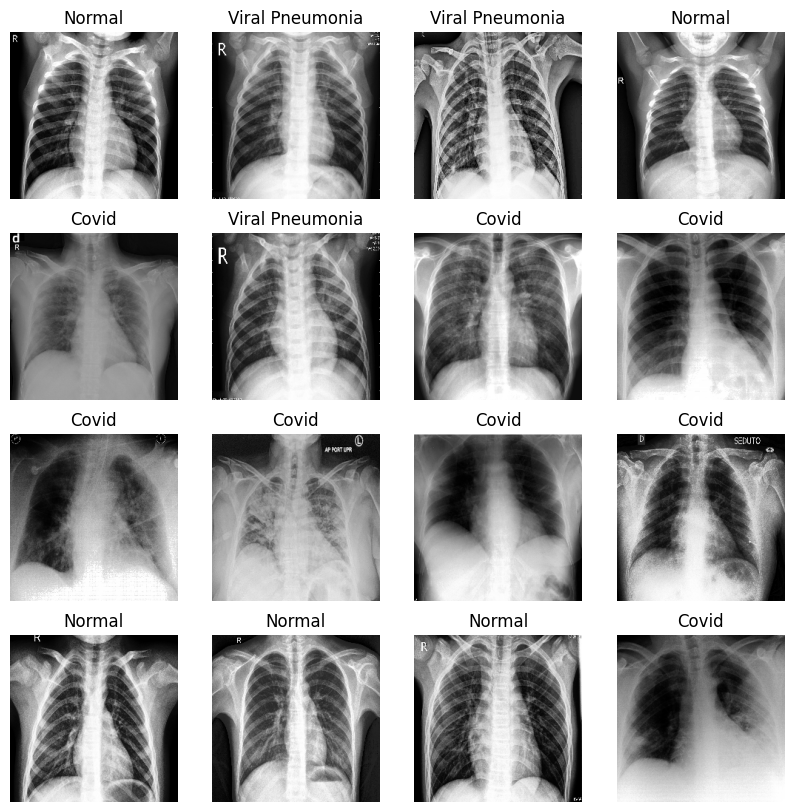

In [7]:
plot_images(train_ds)

Now we can see that all the images are standardised and seem to look similar. But from the public notebook "[COVID19 image classification VGG16 val-acc: 98%](https://www.kaggle.com/code/justicevil/covid19-image-classification-vgg16-val-acc-98)"
 we can see that augmenting (changing the image position, rotation and scale) might be beneficial and might help in increasing the models generalisation and therefore, accuracy.

In the next phase we can eather compare models fitted with unaugmented and augmented images or add these augmented images to ones that are unagmented to encrease the sample size."

In [16]:
def augment_dataset(path):
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        image_size=(height, width),
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        label_mode='categorical',
        class_names=class_names
    )

    aug = tf.keras.Sequential([
       tf.keras.layers.RandomFlip("horizontal"),
       # tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode="constant", fill_value=0.0), # this augmentation seems to be too disruptive (might try later) 
       tf.keras.layers.RandomRotation(20/360, fill_mode="constant", fill_value=0.0), # 20 stupňov
       tf.keras.layers.RandomZoom(0.15, fill_mode="constant", fill_value=0.0),
       tf.keras.layers.Rescaling(1./255)
   ])

    ds = ds.map(lambda x, y: (aug(x), y))
    ds = ds.cache().shuffle(1000)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds


train_ds_aug = augment_dataset(TRAIN_PATH)
test_ds_aug = augment_dataset(TEST_PATH)

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.


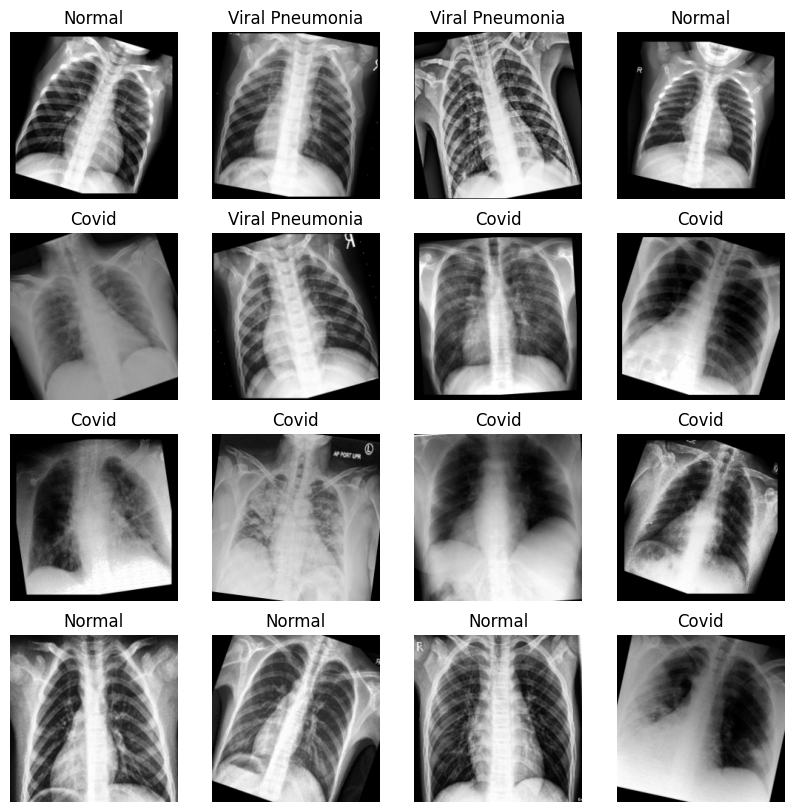

In [17]:
plot_images(train_ds_plot)

After looking at some rather disturbing images let's take a look at mean of each of the classes. We might see some paterns that a CNN might learn.

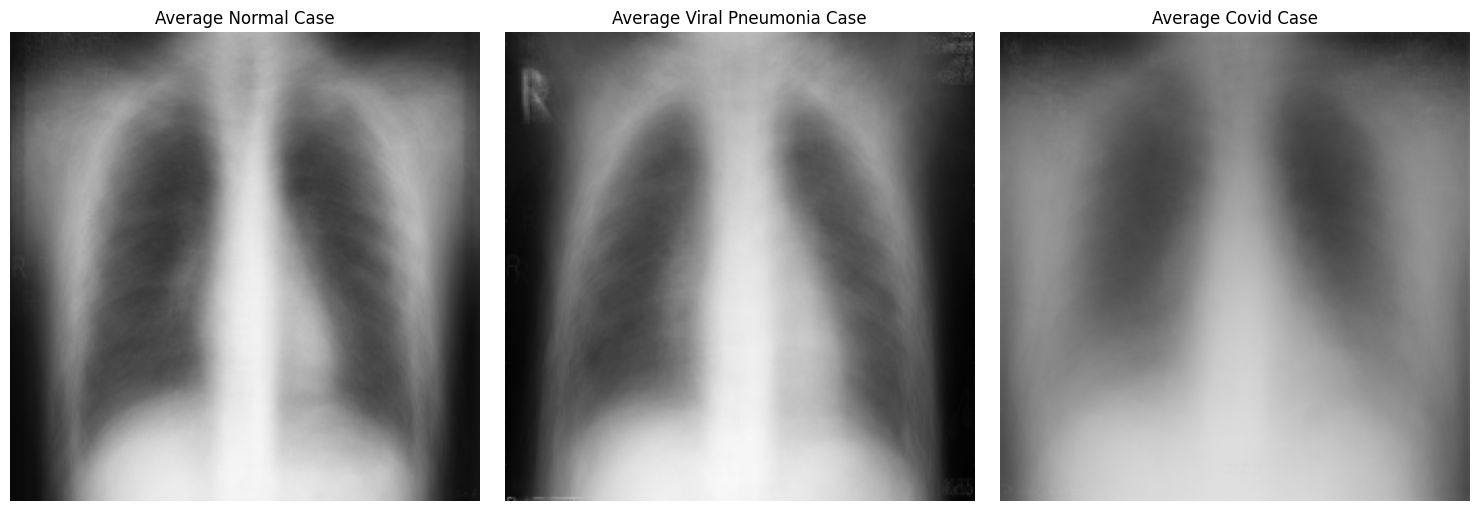

In [18]:
class_sums = {name: None for name in class_names}
class_counts = {name: 0 for name in class_names}

# base black zero image
for c_name in class_names:
    class_sums[c_name] = tf.zeros(shape=(227, 227, 3))

for images, labels in train_ds.as_numpy_iterator():
    for img, label in zip(images, labels):
        class_id = tf.argmax(label)

        class_sums[class_names[class_id]] += img
        class_counts[class_names[class_id]] += 1

mean_img = [None] * 3
for id, class_name in enumerate(class_names):
    mean_img[id] = class_sums[class_name] / class_counts[class_name]

plt.figure(figsize=(15, 5))
for id, class_name in enumerate(class_names):
    plt.subplot(1, 3, id + 1)
    plt.imshow(mean_img[id].numpy())
    plt.title(f'Average {class_name} Case')
    plt.axis('off')

plt.tight_layout()
plt.show()

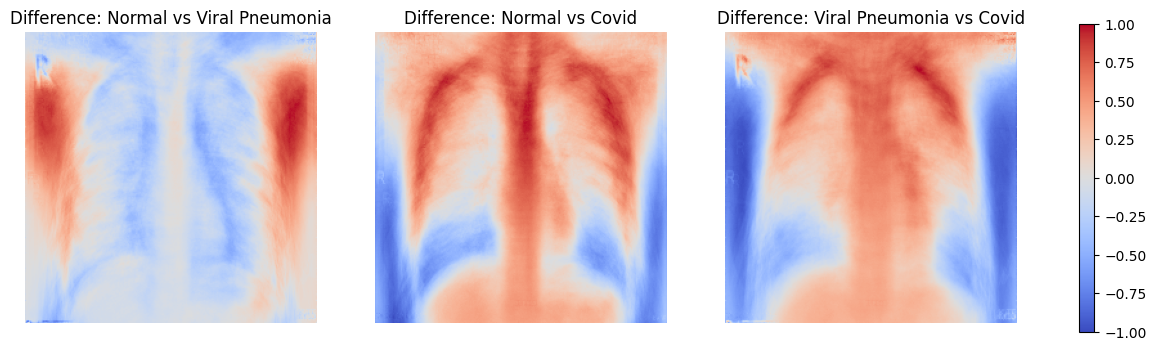

In [19]:
# here we can change the colors to match the images and colorbar
cmap = 'coolwarm'

fig = plt.figure(figsize=(16, 5))
plot_id = 1
for i, class_1 in enumerate(class_names):
    for j, class_2 in enumerate(class_names):
        if i >= j:
            continue
            
        difference = mean_img[i] - mean_img[j]
        
        # took me like one hour to figgure out that plt was confused and thought the image is RGB :)
        difference = tf.reduce_mean(difference, axis=-1) 
        
        fig.add_subplot(1, 3, plot_id)
        plt.imshow(difference.numpy(), cmap=cmap)
        plt.title(f'Difference: {class_1} vs {class_2}')
        plt.axis('off')
        plot_id += 1
        
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(-1, 1), cmap=cmap), ax=fig.axes, orientation='vertical', shrink=0.8)
plt.show()


From this testing we can see that there are some significant difference in the intensity of pixels in each of the classes. These are features that a CNN can pick up on an learn from them.

For this task we chose to use **AlexNet** for our classification task.

### AlexNet

AlexNet was one of the pioneering CNN architectures that demonstrated the potential of deep learning for image classification by winning the 2012 ImageNet competition. Its structure is well-suited for extracting hierarchical features from images.

Compared to more recent architectures (e.g., ResNet or VGG), AlexNet has a simpler design and lower computational requirements, making it a good choice for smaller datasets and 2 week school project :)

-------------------------------------------------------------------------------------------
## 4.2 Modeling and evaluation
-------------------------------------------------------------------------------------------
